## Summary: Transfer Learning for Text with BERT

### What We Accomplished

In this assignment, we successfully implemented **transfer learning for sentiment analysis** using a pre-trained BERT model. Here's what we did:

1. **Loaded the IMDB Dataset**: A collection of 50,000 movie reviews labeled as positive or negative
2. **Used AutoTokenizer**: Converted text into numerical tokens that BERT can process
3. **Tokenized the Dataset**: Prepared text data with padding, truncation, and special tokens
4. **Loaded Pre-trained BERT**: Used `AutoModelForSequenceClassification` with a classification head
5. **Configured Training**: Set up hyperparameters, evaluation strategy, and metrics
6. **Fine-tuned the Model**: Trained BERT on sentiment classification with minimal epochs
7. **Evaluated Performance**: Measured accuracy on the test set

### Key Takeaways

**Transfer Learning Benefits:**
- We started with BERT's pre-trained knowledge from massive text corpora
- Only needed to fine-tune on a small dataset (2,000 examples vs. millions for pre-training)
- Achieved good performance with just 3 epochs of training
- Much faster and more efficient than training from scratch

**BERT Architecture:**
- **Base encoder**: Pre-trained transformer layers that understand language
- **Classification head**: Task-specific layer we fine-tuned for sentiment analysis
- We used different learning rates for the base and head (common in transfer learning)

**Hugging Face Ecosystem:**
- `AutoTokenizer` and `AutoModel` provide a unified interface
- `Trainer` handles the complete training loop automatically
- Easy integration with evaluation metrics

### Next Steps

To improve the model further, you could:
- Use the full dataset (25,000 training examples)
- Experiment with different learning rates and batch sizes
- Try other pre-trained models (RoBERTa, DistilBERT, etc.)
- Add more training epochs or early stopping
- Implement data augmentation techniques
- Fine-tune different layers with different learning rates

This demonstrates how **transfer learning transforms NLP**: instead of requiring massive datasets and computational resources, we can adapt powerful pre-trained models to new tasks with minimal data and training time.

In [ ]:
# Define some test reviews
test_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout.",
    "Terrible film. I wasted 2 hours of my life watching this garbage.",
    "An amazing masterpiece that everyone should watch. Brilliant direction and cinematography.",
    "Boring and predictable. I fell asleep halfway through.",
    "One of the best movies I've ever seen! Highly recommended!",
]

# Function to predict sentiment
def predict_sentiment(text):
    # Tokenize the input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # Move to same device as model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get predicted class (0=negative, 1=positive)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    
    # Get confidence (softmax probabilities)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)[0]
    confidence = probs[prediction].item()
    
    sentiment = "Positive" if prediction == 1 else "Negative"
    return sentiment, confidence

# Test on sample reviews
print("\n" + "="*80)
print("TESTING ON SAMPLE REVIEWS")
print("="*80)

for i, review in enumerate(test_reviews, 1):
    sentiment, confidence = predict_sentiment(review)
    print(f"\nReview {i}:")
    print(f"Text: {review}")
    print(f"Prediction: {sentiment} (Confidence: {confidence*100:.2f}%)")
    print("-"*80)

## Step 8: Test Predictions on Sample Reviews

Let's test our model on some custom movie reviews to see how well it performs.

In [ ]:
# Evaluate the model on the test set
print("Evaluating model on test set...")
eval_results = trainer.evaluate()

print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)
print(f"Test Loss: {eval_results['eval_loss']:.4f}")
print(f"Test Accuracy: {eval_results['eval_accuracy']:.4f} ({eval_results['eval_accuracy']*100:.2f}%)")
print("="*50)

## Step 7: Evaluate the Model

Let's evaluate our fine-tuned BERT model on the test set.

In [ ]:
# Fine-tune the model
print("Starting training...")
train_result = trainer.train()

print("\nTraining completed!")
print(f"Final training loss: {train_result.training_loss:.4f}")
print(f"Training time: {train_result.metrics['train_runtime']:.2f} seconds")

In [ ]:
# Create the Trainer
trainer = Trainer(
    model=model,                           # The model to fine-tune
    args=training_args,                    # Training arguments
    train_dataset=tokenized_train,         # Training dataset
    eval_dataset=tokenized_test,           # Evaluation dataset
    compute_metrics=compute_metrics,       # Metrics function
)

print("Trainer created successfully!")
print(f"Ready to fine-tune on {len(tokenized_train)} training examples")

## Step 6: Create Trainer and Fine-tune BERT

The Trainer handles the training loop, evaluation, and checkpoint management automatically.

In [ ]:
# Configure training arguments
training_args = TrainingArguments(
    output_dir="./bert_sentiment_results",          # Output directory for checkpoints
    eval_strategy="epoch",                          # Evaluate at the end of each epoch
    save_strategy="epoch",                          # Save checkpoint at the end of each epoch
    learning_rate=2e-5,                             # Learning rate for fine-tuning
    per_device_train_batch_size=8,                  # Batch size for training
    per_device_eval_batch_size=8,                   # Batch size for evaluation
    num_train_epochs=3,                             # Number of training epochs
    weight_decay=0.01,                              # Weight decay for regularization
    load_best_model_at_end=True,                    # Load best model at end
    metric_for_best_model="accuracy",               # Metric to use for best model
    logging_dir='./logs',                           # Directory for logs
    logging_steps=50,                               # Log every N steps
    save_total_limit=2,                             # Only keep last 2 checkpoints
)

print("Training arguments configured:")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Output directory: {training_args.output_dir}")

In [ ]:
# Load accuracy metric
accuracy_metric = evaluate.load("accuracy")

# Define function to compute metrics during evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

print("Metrics function configured successfully")

## Step 5: Configure Training Arguments and Metrics

We'll set up:
- Training hyperparameters (learning rate, batch size, epochs)
- Evaluation strategy
- Metric computation (accuracy)

In [ ]:
# Load BERT model for sequence classification
# num_labels=2 for binary classification (negative/positive sentiment)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

print(f"Loaded model: {model_name}")
print(f"Number of parameters: {model.num_parameters():,}")
print(f"\nModel architecture overview:")
print(model)

## Step 4: Load BERT Model for Sequence Classification

We'll use `AutoModelForSequenceClassification` which includes:
- Pre-trained BERT base (encoder)
- A classification head for binary sentiment classification (2 labels: negative/positive)

In [ ]:
# Define tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

# Use a smaller subset for faster training (2000 train, 500 test)
# You can increase these numbers for better performance
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(2000))
small_test_dataset = dataset["test"].shuffle(seed=42).select(range(500))

# Tokenize the datasets
print("Tokenizing datasets...")
tokenized_train = small_train_dataset.map(tokenize_function, batched=True)
tokenized_test = small_test_dataset.map(tokenize_function, batched=True)

print(f"Tokenized train dataset: {len(tokenized_train)} examples")
print(f"Tokenized test dataset: {len(tokenized_test)} examples")
print(f"\nTokenized example keys: {tokenized_train[0].keys()}")

## Step 3: Tokenize the Dataset

We'll create a preprocessing function that tokenizes the text and applies it to the entire dataset.
For efficiency, we'll use a smaller subset of the data for training.

In [ ]:
# Load the BERT tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"Loaded tokenizer: {model_name}")
print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Special tokens: {tokenizer.special_tokens_map}")

## Step 2: Load BERT Tokenizer

We'll use the `bert-base-uncased` pre-trained model and its corresponding tokenizer.
The tokenizer will convert text into numerical tokens that BERT can process.

In [ ]:
# Explore the dataset structure
print("Dataset features:", dataset['train'].features)
print("\nFirst example from training set:")
print(dataset['train'][0])
print("\nDataset splits and sizes:")
print(f"Train: {len(dataset['train'])} examples")
print(f"Test: {len(dataset['test'])} examples")
print("\nLabel distribution (0=negative, 1=positive):")
print(f"Training set - Label 0: {sum(dataset['train']['label']) == 0}, Label 1: {sum(dataset['train']['label'])}")

## Step 1: Explore the IMDB Dataset

Let's examine the structure of the IMDB dataset to understand what we're working with.

# **Introduction to Transfer Learning**

Transfer learning is a machine learning technique where a model trained on one task is re-purposed or fine-tuned for a second related task. Instead of training a deep learning model from scratch, which requires a vast amount of data and computational resources, we can leverage pre-trained models that have already learned powerful features from large datasets. This approach is not limited to image data; it can be effectively applied to various modalities, including text, audio, and more, given a suitable pre-trained model.

## **Why Transfer Learning?**

1.  **Reduced Training Time**: Training complex models from scratch can take days or weeks. Transfer learning significantly cuts down this time by starting with a well-initialized model.
2.  **Less Data Required**: For tasks with limited specific data, a pre-trained model can generalize much better than a model trained only on the small dataset, as it leverages knowledge learned from a much larger dataset.
3.  **Improved Performance**: Pre-trained models often capture hierarchical features (e.g., edges, textures, shapes in images; grammatical structures in text; or temporal patterns in audio) that are useful across various related tasks, leading to better performance even on new, related problems.

## **This Notebook's Implementation**

In this notebook, we demonstrate transfer learning by utilizing a pre-trained **MobileNetV2** model. MobileNetV2 is a lightweight convolutional neural network designed for mobile and embedded vision applications, pre-trained on the massive ImageNet dataset (1.2 million images across 1000 categories). We will adapt this powerful model to classify images from the **Fashion MNIST** dataset, which consists of 10 categories of clothing articles. By doing so, we will showcase how the features learned from ImageNet can be effectively transferred and fine-tuned for a new, but related, image classification task with relatively little data and training.

### Weights & Biases (WandB)

Weights & Biases (WandB) is a machine learning platform designed to help developers track, visualize, and collaborate on their deep learning experiments. It provides tools for:

*   **Experiment Tracking**: Log hyperparameters, metrics, and models to a centralized dashboard.
*   **Visualization**: Generate interactive plots and charts to understand model performance, weights, gradients, and predictions.
*   **Collaboration**: Share experiments, compare results, and work together with teams.
*   **Reproducibility**: Easily re-run experiments and access historical data.
*   **Hyperparameter Optimization**: Integrate with sweep tools to automate hyperparameter tuning.

WandB helps streamline the machine learning workflow, making it easier to develop, debug, and iterate on models.

In [8]:
 #%%capture
%pip install lightning
%pip install wandb pytorch-lightning torchinfo -qqq #wandb logger and torchinfo


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import warnings
warnings.filterwarnings('ignore', message='.*pynvml.*')
warnings.filterwarnings('ignore', category=FutureWarning)
os.environ['PYTHONWARNINGS'] = 'ignore:The pynvml package is deprecated:FutureWarning'

import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision as tv
from torch.utils.data import random_split, DataLoader, Subset
from torchmetrics import Accuracy
import lightning as L
from torchvision import models
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from lightning.pytorch import loggers as pl_loggers

# SSL workaround for certificate verification failed error
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# your favorite machine learning tracking tool
from pytorch_lightning.loggers import WandbLogger
import wandb


<llm-snippet-file>Transfer learning MobileNet Pytorch Lightning.ipynb</llm-snippet-file>


In [12]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("You are using", device)

You are using mps


In [13]:

class MyDataModule(L.LightningDataModule):
    def __init__(self, batch_size=64):
        super().__init__()
        self.batch_size = batch_size
        self.transform_train = tv.transforms.Compose([
            tv.transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
            #tv.transforms.RandomHorizontalFlip(),
            tv.transforms.RandomRotation(10), #data augmentation
            #tv.transforms.RandomCrop(28, padding=4),
            tv.transforms.Resize((224, 224)),  # Resize to MobileNet's input size
            tv.transforms.ToTensor(),
            tv.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjust normalization for 3 channels
        ])
        self.transform_test = tv.transforms.Compose([
            tv.transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
            tv.transforms.Resize((224, 224)),  # Resize to MobileNet's input size
            tv.transforms.ToTensor(),
            tv.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjust normalization for 3 channels
        ])
        self.num_classes = 10

    def prepare_data(self):
        # Download the dataset if it's not already available
        tv.datasets.FashionMNIST(root="./data", train=True, download=True, transform=self.transform_train)
        tv.datasets.FashionMNIST(root="./data", train=False, download=True, transform=self.transform_test)

    def setup(self, stage=None):
        # Data setup for training, validation, and testing
        if stage == 'fit' or stage is None:
            train_dataset = tv.datasets.FashionMNIST(root="./data", train=True, transform=self.transform_train)
            train_set_size = int(len(train_dataset) * 0.8)
            valid_set_size = len(train_dataset) - train_set_size
            seed = torch.Generator().manual_seed(42)
            train_set, valid_set = random_split(train_dataset, [train_set_size, valid_set_size], generator=seed)
            self.train_dataset = train_set
            self.val_dataset = valid_set

        if stage == 'test' or stage is None:
            test_dataset = tv.datasets.FashionMNIST(root="./data", train=False, transform=self.transform_test)
            self.test_dataset = test_dataset

        if stage == 'predict' or stage is None:
            test_dataset = tv.datasets.FashionMNIST(root="./data", train=False, transform=self.transform_test)
            self.predict_dataset = Subset(test_dataset, range(0, 1000))  # Just for predicting and visualizing

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=32) #num_workers=0 default

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=32)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=32)

    def predict_dataloader(self):
        return DataLoader(self.predict_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=32)

<llm-snippet-file>Transfer learning MobileNet Pytorch Lightning.ipynb</llm-snippet-file>


In [4]:
# Obtener la API KEY de forma segura e iniciar sesión en wandb
!wandb login --relogin

wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter: 


Aborted!


In [14]:
import getpass
wandb_key = getpass.getpass("Incerte clave aqui")
wandb.login(key=wandb_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/efrainmanosalvas/.netrc


True

### **Explanation of Transfer Learning Implementation (MobileNetV2Custom Class)**

The following class is at the heart of the transfer learning implementation in your `MobileNetV2Custom` class. It demonstrates how to leverage a pre-trained model and adapt it for a new task. Let's break it down:

1.  **Load a pre-trained MobileNetV2 model**:
```
self.model = models.mobilenet_v2(weights='IMAGENET1K_V2')
```

This line loads the MobileNetV2 architecture. The `weights='IMAGENET1K_V2'` argument is crucial here. It tells PyTorch to download and load the weights that have already been trained on the massive ImageNet dataset. This is the 'transfer' part of transfer learning – we're taking the knowledge gained from a general image recognition task.

2.  **Freeze the base feature extractor if specified**:
```
if freeze_base:
    for param in self.model.features.parameters():
        param.requires_grad = False
```

The MobileNetV2 model is typically composed of two main parts: the `features` (which acts as a feature extractor, learning general image representations like edges, textures, and shapes) and the `classifier` (which makes predictions based on these features). This section checks if `freeze_base` is `True`.
        If `True`, it iterates through all the parameters (`param`) in the `self.model.features` part and sets their `requires_grad` attribute to `False`. This means that during training, the weights of the pre-trained feature extractor will **not** be updated. We rely on its existing, learned features and only train the newly added classifier head.

3.  **Build the classifier head with a customizable number of hidden layers**:
    *   `classifier_layers = []`:
        This initializes an empty list to hold the layers of our new custom classifier.
    *   `input_features = self.model.classifier[1].in_features`:
        MobileNetV2's original classifier has an initial `nn.Linear` layer at index 1. This line extracts the number of input features this original layer expected, which tells us the dimensionality of the features coming out of the pre-trained `features` part of the model. This is the input size for our new custom head.
    *   `if hidden_layers: ...`:
        If `hidden_layers` (a list of integers representing the number of units in each hidden layer) is provided, the code iterates through it to build custom hidden layers. For each `hidden_units` value, it adds:
        *   `nn.Linear(input_features, hidden_units)`: A fully connected (dense) layer.
        *   `nn.BatchNorm1d(hidden_units)`: Batch normalization for stable training.
        *   `nn.LeakyReLU(negative_slope=0.01)`: A LeakyReLU activation function.
        *   `input_features = hidden_units`: Updates the `input_features` for the next layer in the sequence.
    *   `classifier_layers.append(nn.Linear(input_features, num_classes))`:
        Finally, it adds the output layer of the classifier. This is a fully connected layer that maps the features from the previous layer (or the base model if no hidden layers were specified) to the `num_classes` (the number of categories in your Fashion MNIST dataset).
    *   `self.model.classifier = nn.Sequential(*classifier_layers)`:
        This line replaces the original `classifier` part of the MobileNetV2 model with our newly constructed `nn.Sequential` module containing the custom classifier layers.

4.  **Store learning rates and L2 regularization (weight decay) parameters**:
    *   `self.base_lr`, `self.head_lr`, `self.base_weight_decay`, `self.head_weight_decay`:
        These variables store the separate learning rates and weight decay values for the base feature extractor and the new classifier head. This is a common and powerful technique in transfer learning: you often use a much smaller learning rate for the pre-trained base (or freeze it entirely) and a higher learning rate for the new classifier head, as the head needs to learn from scratch for the new task.

In [15]:
class MobileNetV2Custom(L.LightningModule):
    def __init__(self, num_classes, hidden_layers=None, freeze_base=True, base_lr=1e-5, head_lr=1e-3, base_weight_decay=1e-5, head_weight_decay=1e-3):
        """
        Args:
            num_classes (int): Number of output classes for the final classifier.
            hidden_layers (list[int]): List of hidden layer sizes for the classifier head.
            base_lr (float): Learning rate for the base (features) of the model.
            head_lr (float): Learning rate for the classifier head.
            base_weight_decay (float): L2 regularization (weight decay) for the base.
            head_weight_decay (float): L2 regularization (weight decay) for the classifier head.
        """
        super().__init__()

        # Load a pretrained MobileNetV2 model
        self.model = models.mobilenet_v2(weights='IMAGENET1K_V2')

        # Freeze the base feature extractor if specified
        if freeze_base:
            for param in self.model.features.parameters(): #model.features is the base
                param.requires_grad = False

        # Build the classifier head with a customizable number of hidden layers
        classifier_layers = [] #head
        input_features = self.model.classifier[1].in_features
        print("\ninput_features", input_features)
        # Add hidden layers if provided
        if hidden_layers:
            for hidden_units in hidden_layers:
                classifier_layers.append(nn.Linear(input_features, hidden_units))
                classifier_layers.append(nn.BatchNorm1d(hidden_units))
                classifier_layers.append(nn.LeakyReLU(negative_slope=0.01))  # Dropout layer to prevent overfitting
                input_features = hidden_units

        # Add the final layer
        classifier_layers.append(nn.Linear(input_features, num_classes))

        # Replace the classifier in the original model with our new classifier head
        self.model.classifier = nn.Sequential(*classifier_layers)

        # Store learning rates and L2 regularization (weight decay) parameters
        self.base_lr = base_lr
        self.head_lr = head_lr
        self.base_weight_decay = base_weight_decay
        self.head_weight_decay = head_weight_decay

        # Define loss and evaluation metrics
        self.loss = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass",  num_classes=num_classes)

        # logging
        self.log_args = {
            'on_step': True,
            'on_epoch': True,
            'logger': True,
            'prog_bar': True
        }

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        # Parameter groups with different learning rates and weight decay (L2 regularization)
        optimizer = torch.optim.Adam([
            {
                'params': self.model.features.parameters(), #base
                'lr': self.base_lr,
                'weight_decay': self.base_weight_decay # lambda
            },
            {
                'params': self.model.classifier.parameters(), #head
                'lr': self.head_lr,
                'weight_decay': self.head_weight_decay #lambda
            }
        ])
        return optimizer


    def _shared_step(self, batch):
        inputs, labels = batch
        logits = self(inputs) #this calls forward
        loss = self.loss(logits, labels)
        predicted_labels = torch.argmax(logits, dim=1)
        acc = self.accuracy(predicted_labels, labels)

        return loss, acc, labels, predicted_labels


    def training_step(self, batch, batch_idx):
        loss, acc, labels, predicted_labels = self._shared_step(batch)
        self.log('train_loss', loss, **self.log_args)
        self.log('train_acc', acc, **self.log_args)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc, labels, predicted_labels = self._shared_step(batch)
        self.log('val_loss', loss, **self.log_args)
        self.log('val_acc', acc, **self.log_args)
        return loss

    def test_step(self, batch, batch_idx):
        loss, acc, labels, predicted_labels = self._shared_step(batch)
        self.log('test_loss', loss, **self.log_args)
        self.log('test_acc', acc, **self.log_args)
        return loss

    def predict_step(self, batch): #not necessary if dataloader with custom collate for prediction available (see OPTION 3 at the end of the notebook)
        # this calls forward for the inputs only
        inputs, labels = batch
        logits = self(inputs) #return logits, this calls forward
        features = self.model.features(inputs) # forward on the base, used for visualization tsne
        #features has 1280x7x7 feature maps. to reduce is neccesaray global avertage pooling
        #see here https://github.com/pytorch/vision/blob/main/torchvision/models/mobilenetv2.py
        features = nn.functional.adaptive_avg_pool2d(features, (1, 1))
        features = torch.flatten(features, 1) #feature vector 1280x1
        #print(features.shape)
        return features, logits, labels

In [16]:
# Instantiate and prepare the data module
dm = MyDataModule(batch_size=32) #default 32
dm.prepare_data()
dm.setup()

# Instantiate the model
num_classes = dm.num_classes
hidden_layers = [256, 256, 256]  # Define hidden layers as needed. default 64,64
model = MobileNetV2Custom(num_classes=num_classes,
                          hidden_layers=hidden_layers,
                          freeze_base=False, #unfreeze
                          base_lr=1e-5,
                          head_lr=1e-3,
                          base_weight_decay = 0,
                          head_weight_decay = 0)




input_features 1280


In [18]:
from torchinfo import summary
# Use torchinfo to print the summary
# summary(model.to(device), input_size=(1, 3, 224, 224), device=device)
summary(model, input_size=(1, 3, 224, 224), device=device)

print(model)

MobileNetV2Custom(
  (model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_siz

In [19]:
wandb.init(project="TransferLearning",
           #id='r3ob5fos',
           #resume=True
           )

In [20]:
#tb_logger = pl_loggers.TensorBoardLogger(save_dir="logs_mobilenetv2/")

# Initialize Callbacks
early_stop_callback = L.pytorch.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20)
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(save_top_k=5, save_last=True, monitor="val_loss", mode='min')



In [21]:
# Train the model
trainer = L.Trainer(
    max_epochs=1000,
    callbacks=[early_stop_callback, checkpoint_callback],
    accelerator="auto", # Automatically detects mps, cuda or cpu
    devices=1,
    strategy="auto",
    logger=WandbLogger(project="TransferLearning")
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


In [22]:
#ckpt_path = '/content/TransferLearning/x8w7kq6f/checkpoints/last.ckpt'
trainer.fit(model, dm, ckpt_path='last')
#/content/TransferLearning/x8w7kq6f/checkpoints/last.ckpt

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:190: .fit(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded. HINT: Set `ModelCheckpoint(..., save_last=True)`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:400: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model    │ MobileNetV2        │  2.7 M │ train │     0 │
│ 1 │ loss     │ CrossEntropyLoss   │      0 │ train │     0 │
│ 2 │ accuracy │ MulticlassAccuracy │      0 │ train │     0 │
└───┴──────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 2.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.7 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 223                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connector
s/data_connector.py:429: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader 
worker initialization.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connector
s/data_connector.py:429: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the 
dataloader worker initialization.

In [23]:
trainer.validate(model, dataloaders=dm.val_dataloader(), ckpt_path='best')

Restoring states from the checkpoint path at ./TransferLearning/a02z3roh/checkpoints/epoch=12-step=19500.ckpt
Loaded model weights from the checkpoint at ./TransferLearning/a02z3roh/checkpoints/epoch=12-step=19500.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9225000143051147     │
│      val_loss_epoch       │    0.2254829704761505     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.2254829704761505, 'val_acc_epoch': 0.9225000143051147}]

In [24]:
trainer.test(model, dataloaders=dm.test_dataloader(), ckpt_path='best')

Restoring states from the checkpoint path at ./TransferLearning/a02z3roh/checkpoints/epoch=12-step=19500.ckpt
Loaded model weights from the checkpoint at ./TransferLearning/a02z3roh/checkpoints/epoch=12-step=19500.ckpt
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:429: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.9243999719619751     │
│      test_loss_epoch      │    0.21960100531578064    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.21960100531578064,
  'test_acc_epoch': 0.9243999719619751}]

In [25]:
predictions = trainer.predict(model, dataloaders=dm.predict_dataloader(), ckpt_path='best')

Restoring states from the checkpoint path at ./TransferLearning/a02z3roh/checkpoints/epoch=12-step=19500.ckpt
Loaded model weights from the checkpoint at ./TransferLearning/a02z3roh/checkpoints/epoch=12-step=19500.ckpt
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:429: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


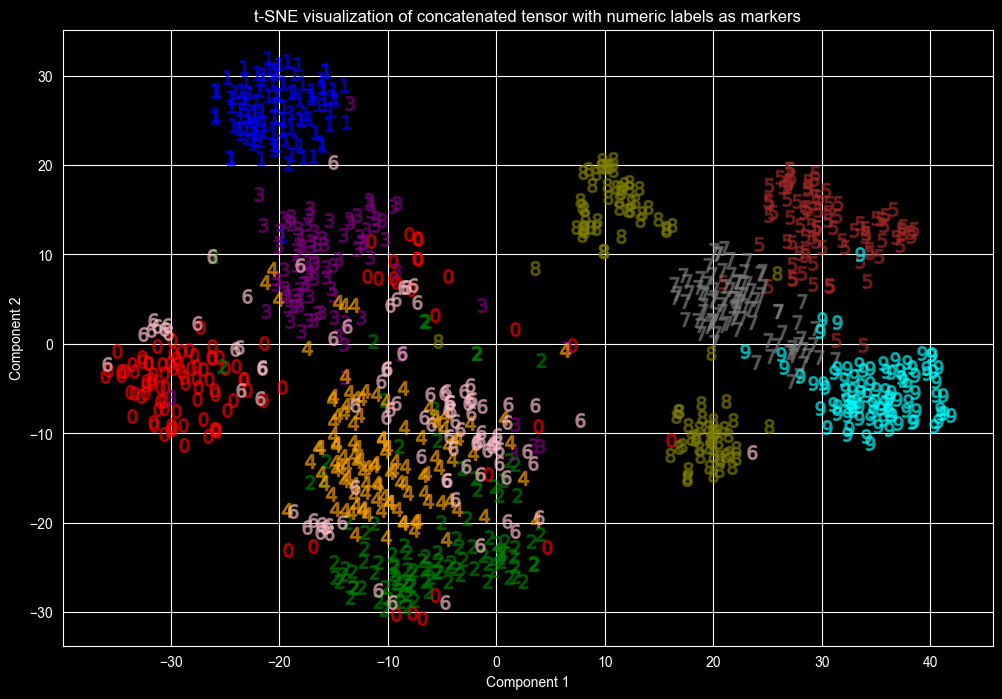

In [26]:

import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

#predict_step returns tuple of (features, logits, labels)

features_list_of_tensors = [out_tuple[0] for out_tuple in predictions] #out_tuple[0] are features
concatenated_feature_tensor = torch.cat(features_list_of_tensors, dim=0)

labels_list_of_tensors = [out_tuple[2] for out_tuple in predictions] #out_tuple[2] are labels
concatenated_labels_tensor = torch.cat(labels_list_of_tensors, dim=0)


# Convert the tensor to a NumPy array if it's not already
features = concatenated_feature_tensor.cpu().detach().numpy()  # Move to CPU and convert to numpy if not already
labels =  concatenated_labels_tensor.cpu().detach().numpy()  # Move to CPU and convert to numpy if not already

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data to standardize it
normalized_features = scaler.fit_transform(features)

# Initialize t-SNE with two components (2D visualization)
tsne = TSNE(n_components=2, random_state=42)

# Apply t-SNE transformation on the data
reduced_data = tsne.fit_transform(normalized_features)

# Define a color map and marker list (can extend or modify these for more labels or preferences)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
markers = ['o', '^', 's', 'P', '*', 'x', 'D', 'H', 'v', '>']


# Create the plot
plt.figure(figsize=(12, 8))

# Define a color map (one color for each label)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

# Plot each class with its own color and use the label number as the marker
for i in range(10):  # Assumes labels are from 0 to 9
    idx = labels == i
    plt.scatter(reduced_data[idx, 0], reduced_data[idx, 1], color=colors[i], alpha=0.5, edgecolors=colors[i],
                s=100,  # Adjust size for better visibility
                marker=f"${i}$")  # Use TeX rendering for numeric markers

# Add features to the plot
plt.title('t-SNE visualization of concatenated tensor with numeric labels as markers')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()



In [27]:
wandb.finish()

epoch,▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇████
test_acc_epoch,▁
test_acc_step,▄▆▅▇▃▆▆▅▅▇▅█▅▄▆▅▆▁▇▇▄▇▆▅▄▄█▅▅▄▆▄▅█▆▅▅▄▅▇
test_loss_epoch,▁
test_loss_step,▅▂▅▄▂▂▄▃▄▁▂▄▄▃▃▂▂▃▃▃▂▅▄▃▅▆▃▂▆▂▃▁▃▄▃█▃▄▆▇
train_acc_epoch,▁▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████
train_acc_step,▅▁▄▄▁▁▇▅█▄▇▄▅▄▂▁▇▄▄█▄▄▅▇▇██▇█▄█▅█▇███▅▇▇
train_loss_epoch,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▄▇▅▆▄▄█▂▃▄▂▂▄▄▅▂▃▁▂▃▂▃▃▁▂▂▂▃▂▁▁▂▁▁▁▂▁▁▁▇
trainer/global_step,▁▂▁▃▁▂▂▂▂▂▂▂▂▂▂▂▇▇▂▃█▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▁
+4,...




#✅ **Assignment: Transfer Learning for Text — Sentiment Classification with BERT**

In this assignment, you will explore the use of transfer learning in Natural Language Processing by fine-tuning a pre-trained BERT model using the Hugging Face library. Your objective is to build a sentiment classifier capable of distinguishing between positive and negative movie reviews.

Pre-trained language models such as BERT have been trained on massive text corpora and already encode rich semantic and contextual information. By fine-tuning BERT on a smaller labeled dataset, you will adapt its representations to the specific task of sentiment analysis with minimal training effort.

In the next section, the IMDB movie reviews dataset will be loaded, which you will use to train and evaluate your classifier.

**🧩 What Is a Tokenizer?**

Before fine-tuning BERT, it is essential to understand what a tokenizer does.
A tokenizer converts raw text into numerical inputs that a language model can understand.

A tokenizer:
* Splits text into tokens (words, subwords, or characters).
Example: “unbelievable” → “un”, “believable”

* Maps each token to an integer ID using the model’s vocabulary
* Adds special tokens required by the model (e.g., [CLS], [SEP] for BERT)
* Creates attention masks to indicate which tokens are padding
* Optionally truncates or pads sequences to a fixed length

In short:
👉 The tokenizer prepares text; the model processes numbers.

Because tokenization depends on how a model was pre-trained, you must always use the tokenizer that corresponds to the model.

**🤖 Using AutoTokenizer and AutoModel in Hugging Face**

The Hugging Face ecosystem provides convenient Auto classes that automatically load the correct:
* architecture
* weights
* configuration
* tokenizer

based on the model name.

**✅ AutoTokenizer**

Loads the correct tokenizer for any model:

```
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
```

This ensures:
* correct vocabulary
* correct pre-processing
* correct special tokens
* compatibility with the model

**✅ AutoModel / AutoModelForSequenceClassification**

Loads the correct model architecture with pretrained weights:
```
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")
```
Hints:
* Use AutoModelForSequenceClassification — it already includes a classification head.
* Use AutoTokenizer with the same model name to ensure compatibility.
* No need to manually build embeddings or architectures; the model is already pre-trained.


**🏗️ How Auto Classes Fit into the Hugging Face Ecosystem**

The Auto classes form a unified interface to access hundreds of models hosted on the Hugging Face Hub.

Here are the most used auto classes:

**AutoTokenizer:**	Loads the correct tokenizer for any model

**AutoConfig:**	Loads model configuration (hidden size, labels, dropout, etc.)

**AutoModel:**	Loads the base architecture without a task-specific head

**AutoModelForSequenceClassification:**	Loads the architecture plus a classification head

**AutoModelForQuestionAnswering, etc.:**	Variants for other tasks

All models and tokenizers loaded this way:
* follow a consistent API
* work seamlessly with Hugging Face’s Trainer
* ensure that tokenizer + model are always compatible

**🧠 Summary**
* A tokenizer converts raw text into model-readable inputs.
* You must use the tokenizer that matches your pre-trained model.
* AutoTokenizer and AutoModel simplify loading pre-trained components.
* They ensure consistency across models and tasks.
* You will use them to prepare text and fine-tune BERT on the IMDB sentiment classification task.



In [29]:
#!pip install transformers datasets accelerate -qqq
!pip install transformers accelerate datasets evaluate -qqq

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
import numpy as np
import evaluate
import torch

# Load a public sentiment dataset (e.g., IMDb reviews)
dataset = load_dataset('imdb')

# Display some information about the dataset
print(dataset)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [3]:
# Step 1: Explore the IMDB Dataset
print("Dataset features:", dataset['train'].features)
print("\nFirst example from training set:")
print(dataset['train'][0])
print("\nDataset splits and sizes:")
print(f"Train: {len(dataset['train'])} examples")
print(f"Test: {len(dataset['test'])} examples")

Dataset features: {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}

First example from training set:
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />Wha

In [4]:
# Step 2: Load BERT Tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"Loaded tokenizer: {model_name}")
print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Special tokens: {tokenizer.special_tokens_map}")

Loaded tokenizer: bert-base-uncased
Vocabulary size: 30522
Special tokens: {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}


In [5]:
# Step 3: Tokenize the Dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

# Use a smaller subset for faster training (2000 train, 500 test)
# You can increase these numbers for better performance
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(2000))
small_test_dataset = dataset["test"].shuffle(seed=42).select(range(500))

# Tokenize the datasets
print("Tokenizing datasets...")
tokenized_train = small_train_dataset.map(tokenize_function, batched=True)
tokenized_test = small_test_dataset.map(tokenize_function, batched=True)

print(f"Tokenized train dataset: {len(tokenized_train)} examples")
print(f"Tokenized test dataset: {len(tokenized_test)} examples")
print(f"\nTokenized example keys: {tokenized_train[0].keys()}")

Tokenizing datasets...


Map: 100%|██████████| 500/500 [00:00<00:00, 7581.26 examples/s]

Tokenized train dataset: 2000 examples
Tokenized test dataset: 500 examples

Tokenized example keys: dict_keys(['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])


In [6]:
# Step 4: Load BERT Model for Sequence Classification
# num_labels=2 for binary classification (negative/positive sentiment)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

print(f"Loaded model: {model_name}")
print(f"Number of parameters: {model.num_parameters():,}")
print(f"\nModel architecture overview:")
print(model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded model: bert-base-uncased
Number of parameters: 109,483,778

Model architecture overview:
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(i

In [7]:
# Step 5: Configure Training Arguments and Metrics
# Load accuracy metric
accuracy_metric = evaluate.load("accuracy")

# Define function to compute metrics during evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

print("Metrics function configured successfully")

Metrics function configured successfully


In [8]:
# Configure training arguments
training_args = TrainingArguments(
    output_dir="./bert_sentiment_results",          # Output directory for checkpoints
    eval_strategy="epoch",                          # Evaluate at the end of each epoch
    save_strategy="epoch",                          # Save checkpoint at the end of each epoch
    learning_rate=2e-5,                             # Learning rate for fine-tuning
    per_device_train_batch_size=8,                  # Batch size for training
    per_device_eval_batch_size=8,                   # Batch size for evaluation
    num_train_epochs=3,                             # Number of training epochs
    weight_decay=0.01,                              # Weight decay for regularization
    load_best_model_at_end=True,                    # Load best model at end
    metric_for_best_model="accuracy",               # Metric to use for best model
    logging_dir='./logs',                           # Directory for logs
    logging_steps=50,                               # Log every N steps
    save_total_limit=2,                             # Only keep last 2 checkpoints
)

print("Training arguments configured:")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Output directory: {training_args.output_dir}")

Training arguments configured:
  Learning rate: 2e-05
  Batch size: 8
  Epochs: 3
  Output directory: ./bert_sentiment_results


In [9]:
# Step 6: Create the Trainer
trainer = Trainer(
    model=model,                           # The model to fine-tune
    args=training_args,                    # Training arguments
    train_dataset=tokenized_train,         # Training dataset
    eval_dataset=tokenized_test,           # Evaluation dataset
    compute_metrics=compute_metrics,       # Metrics function
)

print("Trainer created successfully!")
print(f"Ready to fine-tune on {len(tokenized_train)} training examples")

Trainer created successfully!
Ready to fine-tune on 2000 training examples


In [10]:
# Step 7: Fine-tune the Model
print("Starting training...")
train_result = trainer.train()

print("\nTraining completed!")
print(f"Final training loss: {train_result.training_loss:.4f}")
print(f"Training time: {train_result.metrics['train_runtime']:.2f} seconds")

Starting training...


wandb: Currently logged in as: angel-manosalvas (angel-manosalvas-laumayer) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tok

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.288800,0.303857,0.904000
2,0.155100,0.415466,0.900000
3,0.072700,0.426273,0.906000


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Training completed!
Final training loss: 0.2289
Training time: 558.23 seconds


In [11]:
# Step 8: Evaluate the Model
print("Evaluating model on test set...")
eval_results = trainer.evaluate()

print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)
print(f"Test Loss: {eval_results['eval_loss']:.4f}")
print(f"Test Accuracy: {eval_results['eval_accuracy']:.4f} ({eval_results['eval_accuracy']*100:.2f}%)")
print("="*50)

Evaluating model on test set...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



EVALUATION RESULTS
Test Loss: 0.4263
Test Accuracy: 0.9060 (90.60%)


In [12]:
# Step 9: Test Predictions on Sample Reviews
# Define some test reviews
test_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout.",
    "Terrible film. I wasted 2 hours of my life watching this garbage.",
    "An amazing masterpiece that everyone should watch. Brilliant direction and cinematography.",
    "Boring and predictable. I fell asleep halfway through.",
    "One of the best movies I've ever seen! Highly recommended!",
]

# Function to predict sentiment
def predict_sentiment(text):
    # Tokenize the input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # Move to same device as model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get predicted class (0=negative, 1=positive)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    
    # Get confidence (softmax probabilities)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)[0]
    confidence = probs[prediction].item()
    
    sentiment = "Positive" if prediction == 1 else "Negative"
    return sentiment, confidence

# Test on sample reviews
print("\n" + "="*80)
print("TESTING ON SAMPLE REVIEWS")
print("="*80)

for i, review in enumerate(test_reviews, 1):
    sentiment, confidence = predict_sentiment(review)
    print(f"\nReview {i}:")
    print(f"Text: {review}")
    print(f"Prediction: {sentiment} (Confidence: {confidence*100:.2f}%)")
    print("-"*80)


TESTING ON SAMPLE REVIEWS

Review 1:
Text: This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout.
Prediction: Positive (Confidence: 99.79%)
--------------------------------------------------------------------------------

Review 2:
Text: Terrible film. I wasted 2 hours of my life watching this garbage.
Prediction: Negative (Confidence: 99.70%)
--------------------------------------------------------------------------------

Review 3:
Text: An amazing masterpiece that everyone should watch. Brilliant direction and cinematography.
Prediction: Positive (Confidence: 99.78%)
--------------------------------------------------------------------------------

Review 4:
Text: Boring and predictable. I fell asleep halfway through.
Prediction: Negative (Confidence: 99.47%)
--------------------------------------------------------------------------------

Review 5:
Text: One of the best movies I've ever seen! Highly recommended!
Prediction: Positive (Con